In [1]:
import os
# Disable tokenizers parallelism
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

In [2]:
!pip install datasets evaluate transformers[sentencepiece]
!pip install accelerate -U

In [3]:
import pandas as pd
from datasets import load_dataset
from transformers import AutoTokenizer, DataCollatorWithPadding
import evaluate
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import Dataset
from torch.cuda import amp
from transformers import AutoModel, AutoTokenizer,AutoConfig
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,f1_score
import torch
import warnings
import random
warnings.filterwarnings('ignore')
from collections import defaultdict
import torch.nn as nn
from transformers import get_scheduler
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
from collections import defaultdict
import gc
gc.enable()

2025-11-25 08:48:27.992000: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764060508.013775     151 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764060508.020511     151 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [4]:
def set_random_seed(random_seed):
    random.seed(random_seed)
    np.random.seed(random_seed)
    os.environ["PYTHONHASHSEED"] = str(random_seed)

    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)

    torch.backends.cudnn.deterministic = True

In [5]:
from huggingface_hub import notebook_login
notebook_login()

In [6]:
df = pd.read_csv("hf://datasets/Ayon128/CB/final_CB_multi-label_dataset.csv")
df.shape

(5089, 8)

In [7]:
with pd.option_context('display.max_colwidth',0):
    display(df.sample(n=5))

,Comment,Profession,Gender,Labels,Trolling,Insult,Hate Speech,Targeted Harassment
4276,ভোদা কবির।তোর নাটকের কপালে জুতা ও থুতু মারি।তোরে আনলাইক দিলাম।,Actor,Female,"Trolling, Insult, Targeted Harassment",1,1,0,1
2135,"যারা পরকালে বিশ্বাস করেনা, তাদের বাংলায় ঠাই নেই, কারন এই দেশ শাহ-জালাল( রঃ) এর দেশ। এই দেশ আল্লামা শাহ- আহমদ শফীর দেশ, এই দেশ মুফতী ফজলুল হক -আমিনীর (রঃ) এর দেশ, সুতরাং এই দেশে কোনো নাস্তিকদের থাকতে দেওয়া হবে না।",Actor,Female,"Hate Speech, Targeted Harassment",0,0,1,1
714,শুন আমি তোমাকে খুভ বালোভাসতাম।কিন্থু তুমি যা করলা আমি সেইতা শুনে খুভ কান্না করচি জানো?লাইভে আইসা মাফ চাও আগে। তবে হ্যা আসার আগে অযু করে আসবা।অকেয়?আর তুমার নামের আগে মোসাম্মাৎ সাফা কবির দিবা।নাইলে সাফা রিদম দেও।,Actor,Female,"Trolling, Targeted Harassment",1,0,0,1
226,"তার বলা লাগবে না, সরকার বদলেছে তাতেই হবে.আগে সাফা কবিরের উচিত পরকালের উপর পরিপূর্ণ বিশ্বাস রাখা",Actor,Female,"Trolling, Insult",1,1,0,0
4429,তোর নাম তাসলিমা নাসরিন কেন রাখলো তোর নামতো মোসোল মানের নাম তুই হিন্দু নাম রাখতি খাচ্চরের বাচ্চা আচ্ছা লজ্জা হয়না দুইদিন ধরে ইন্ডিয়া গিয়ে দালালি করছো মুসলমানদের বদনাম বলোছ তুই এতো বড় মাপের বাল পাকনা জে তোর কথা শুনে অবাক হই আরে ফকিন্নির বাচ্চা মালাউনের মেয়ে তোর মতো পতিতার থেকে অনেক বড় মাপের লোক চাদের দেশে গিয়ে আজানের সব্দ শুনে মুসলিম হইছে তুই একটা ভুল দেখা কোরানের তাইলে আমি তোর পক্ষে কথা বলুম না দেখাওতে পারলে তুই ইসলাম এর নামে বদনাম করিস না জাহান্নামি,Social,Female,"Insult, Hate Speech, Targeted Harassment",0,1,1,1


In [8]:
df.columns

Index(['Comment', 'Profession', 'Gender', 'Labels', 'Trolling', 'Insult',
       'Hate Speech', 'Targeted Harassment'],
      dtype='object')

In [9]:
from sklearn.model_selection import train_test_split
# split into train and test
df_train, df_test = train_test_split(df, random_state=1, test_size=0.3, shuffle=True)
# split test into test and validation datasets
df_test, df_valid = train_test_split(df_test, random_state=1, test_size=0.50, shuffle=True)

In [10]:
df_train.shape, df_test.shape, df_valid.shape

((3562, 8), (763, 8), (764, 8))

In [11]:
df_test.head()

,Comment,Profession,Gender,Labels,Trolling,Insult,Hate Speech,Targeted Harassment
1720,বাপ জেমন মেয়েত তেমনি হবে এটাতো তাদের রেচালা।,Actor,Female,"Insult, Hate Speech, Targeted Harassment",0,1,1,1
2702,জুতা মারি তোর চোয়ালে বেটা বেয়াদব । এজন্যই তো ত...,Singer,Female,"Insult, Targeted Harassment",0,1,0,1
4740,"সালা বেগাচেগা তুই লাইভে আসিস কি করতে, আয়নায় কো...",Social,Male,"Trolling, Insult, Targeted Harassment",1,1,0,1
4076,জুতা মার।ছাগলের বাচ্চা,Social,Male,"Insult, Targeted Harassment",0,1,0,1
2445,ওর নোংরা ছবিটা পোস্ট না করে শুধু লেখাটা রাখলেই...,Actor,Female,"Trolling, Insult",1,1,0,0


In [12]:
# checkpoint = "csebuetnlp/banglabert" "sagorsarker/bangla-bert-base" "csebuetnlp/banglabert_large"
class Config:
    NUM_EPOCHS = 15
    BATCH_SIZE = 16
    MODEL_PATH = "csebuetnlp/banglabert"
    LR = 3e-5
    DROPOUT = 0.3
    NUM_CLASSES = 4
    SEED = 123
    MAX_LEN = 128
    DEVICE =  "cuda" if torch.cuda.is_available() else "cpu"

config  = Config()

In [13]:
tokenizer = AutoTokenizer.from_pretrained(config.MODEL_PATH)

<Axes: ylabel='Count'>

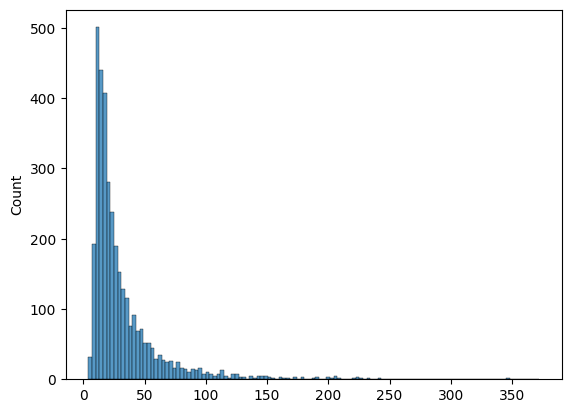

In [14]:
token_counts = []

for _, row in df_train.iterrows():
    text = str(row["Comment"])  # Ensure the text is converted to a string
    token_count = len(tokenizer.encode(
        text,
        max_length=512,
        truncation=True
    ))
    token_counts.append(token_count)

sns.histplot(token_counts)

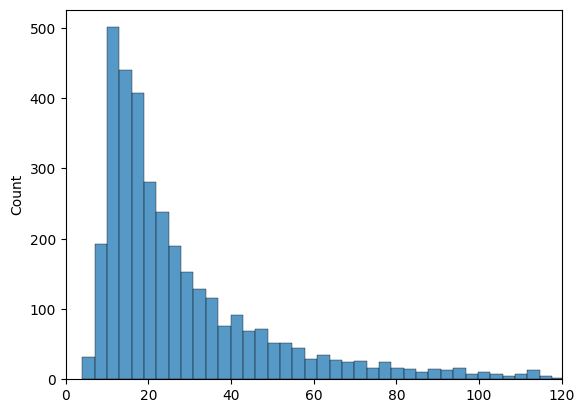

In [15]:
sns.histplot(token_counts)
plt.xlim([0, 120]);

<Axes: ylabel='Count'>

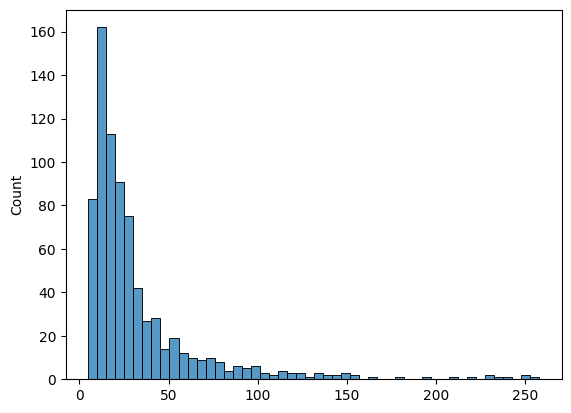

In [16]:
token_counts = []

for _, row in df_valid.iterrows():
    text = str(row["Comment"])  # Ensure the text is converted to a string
    token_count = len(tokenizer.encode(
        text,
        max_length=512,
        truncation=True
    ))
    token_counts.append(token_count)

sns.histplot(token_counts)

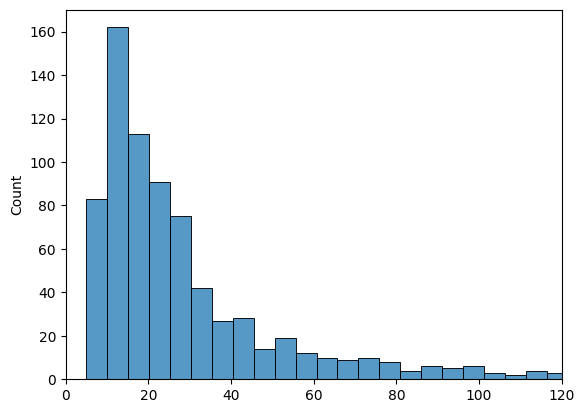

In [17]:
sns.histplot(token_counts)
plt.xlim([0, 120]);

In [18]:
class ClassifierDataset(Dataset):
    def __init__(self, df,tokenizer, target_list):
        super(ClassifierDataset, self).__init__()
        self.df = df 
        self.targets = self.df[target_list].values
        # self.labels = torch.tensor(df.Label.values, dtype=torch.long)
        self.tokenizer = tokenizer
        self.max_length = config.MAX_LEN

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        text = str(self.df.iloc[index]["Comment"])
        inputs = self.tokenizer(
            text,
            padding=True, 
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )
        input_ids = inputs["input_ids"].squeeze(0)
        attention_mask = inputs["attention_mask"].squeeze(0)
        # labels = self.labels[index]
        labels = torch.FloatTensor(self.targets[index])

        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": labels
        }

In [19]:
target_list = list(df.columns)
target_list

['Comment',
 'Profession',
 'Gender',
 'Labels',
 'Trolling',
 'Insult',
 'Hate Speech',
 'Targeted Harassment']

In [20]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [21]:
target_list = target_list[4:]

In [22]:
target_list

['Trolling', 'Insult', 'Hate Speech', 'Targeted Harassment']

In [23]:
import torch.nn.functional as F
class LSTMPooling(nn.Module):
    def __init__(self, num_layers, hidden_size, hiddendim_lstm):
        super(LSTMPooling, self).__init__()
        self.num_hidden_layers = num_layers
        self.hidden_size = hidden_size
        self.hiddendim_lstm = hiddendim_lstm
        self.lstm = nn.LSTM(self.hidden_size, self.hiddendim_lstm, batch_first=True)
        self.dropout = nn.Dropout(0.2)
    
    def forward(self, all_hidden_states):
        ## forward
        hidden_states = torch.stack([all_hidden_states[layer_i][:, 0].squeeze()
                                     for layer_i in range(1, self.num_hidden_layers+1)], dim=-1)
        hidden_states = hidden_states.view(-1, self.num_hidden_layers, self.hidden_size)
        out, _ = self.lstm(hidden_states, None)
        out = self.dropout(out[:, -1, :])
        return out

In [24]:
class ClassifierModel(nn.Module):
    def __init__(self):
        super(ClassifierModel, self).__init__()
        self.model_config = AutoConfig.from_pretrained(config.MODEL_PATH)
        self.model = AutoModel.from_pretrained(
            config.MODEL_PATH, 
            config=self.model_config
        )
        # LSTM pooler
        self.lstm_pooler = LSTMPooling(
            self.model_config.num_hidden_layers, 
            self.model_config.hidden_size, 
            768
        )
        
        # Combined dimension: LSTM hidden dim + model hidden size (for CLS token)
        combined_dim = 768 + self.model_config.hidden_size
        
        self.dropout = torch.nn.Dropout(config.DROPOUT)
        # Classifier takes the combined dimension as input
        self.classifier = nn.Linear(combined_dim, config.NUM_CLASSES)
        
    def forward(self, input_ids, attention_mask):
        # Get hidden states from the model
        outputs = self.model(
            input_ids=input_ids, 
            attention_mask=attention_mask,
            output_hidden_states=True
        )
        
        # Get all hidden states
        all_hidden_states = outputs.hidden_states
        
        # Get LSTM pooled representation
        lstm_output = self.lstm_pooler(all_hidden_states)
        
        # Get CLS token from the last layer
        cls_output = all_hidden_states[-1][:, 0]
        
        # Concatenate CLS and LSTM outputs
        combined = torch.cat([cls_output, lstm_output], dim=-1)
        
        # Apply dropout and classifier
        output_dropout = self.dropout(combined)
        output = self.classifier(output_dropout)
        
        return output

In [25]:
class Engine:
    def __init__(self, model, optimizer,scheduler = None):
        self.model = model
        self.optimizer = optimizer
        self.scheduler = scheduler
        
    @staticmethod
    def loss_fn(target, pred):
        loss_fct = nn.BCEWithLogitsLoss()
        loss = loss_fct(pred,target)
        return loss
    
    @staticmethod
    def compute_metrics(labels, pred):
        y_true = labels.cpu().numpy()
        y_pred = torch.sigmoid(pred).cpu().detach().numpy().round()
        f1 = f1_score(y_true, y_pred, average='macro')
        return f1
        
    def train(self, train_dataloader,scaler,num_training_steps):
        self.model.train()
        total_training_loss = 0.0
        progress_bar = tqdm(range(num_training_steps))
        for data in train_dataloader:
            input_ids = data["input_ids"].to(config.DEVICE)
            attention_mask = data["attention_mask"].to(config.DEVICE)            
            target = data["labels"].to(config.DEVICE)
            self.optimizer.zero_grad()
            
            with amp.autocast():
                pred = self.model(input_ids, attention_mask)
                loss = self.loss_fn(target,pred)
                
            total_training_loss += loss.item()
            scaler.scale(loss).backward()
            nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            scaler.step(self.optimizer)
            scaler.update()
            if self.scheduler:
                self.scheduler.step()
            progress_bar.update(1)
                
        return total_training_loss / len(train_dataloader)
    
    def evaluate(self,eval_dataloader):
        self.model.eval()
        val_loss = 0
        score = 0.0
        with torch.no_grad():
            for data in tqdm(eval_dataloader):
                input_ids = data["input_ids"].to(config.DEVICE)  
                attention_mask = data["attention_mask"].to(config.DEVICE)              
                target = data["labels"].to(config.DEVICE)  
                
                pred = self.model(input_ids, attention_mask)
                loss = self.loss_fn(target,pred)
                val_loss += loss.item()
                batch_score = self.compute_metrics(target,pred)
                score+= batch_score
             
            score = score / len(eval_dataloader)
            val_loss = val_loss / len(eval_dataloader)
        
        return score, val_loss

In [26]:
# Run training function with improved training procedure
from transformers import get_cosine_schedule_with_warmup
history = defaultdict(list)
def run_training(save_model = False):
    train_dataset = ClassifierDataset(df_train, tokenizer, target_list)
    valid_dataset = ClassifierDataset(df_valid, tokenizer, target_list)
    
    train_loader = DataLoader(
        train_dataset, 
        batch_size=config.BATCH_SIZE,
        collate_fn=data_collator, 
        shuffle=True, 
        num_workers=2
    )    
    
    val_loader = DataLoader(
        valid_dataset, 
        batch_size=config.BATCH_SIZE,
        collate_fn=data_collator, 
        shuffle=False, 
        num_workers=2
    )   
    
    set_random_seed(config.SEED)
    model = ClassifierModel()
    model.to(config.DEVICE)
    
    # Use differential learning rates
    optimizer_grouped_parameters = [
        # BanglaBERT parameters
        {
            'params': [p for n, p in model.named_parameters() if 'model' in n],
            'lr': config.LR,
            'weight_decay': 0.01
        },
        # Task-specific parameters (including LSTM)
        {
            'params': [p for n, p in model.named_parameters() if 'model' not in n],
            'lr': config.LR * 3,  # Higher learning rate for task-specific layers
            'weight_decay': 0.01
        }
    ]
    
    optimizer = torch.optim.AdamW(optimizer_grouped_parameters)
    num_training_steps = config.NUM_EPOCHS * len(train_loader)
    warmup_steps = int(0.1 * num_training_steps) 
    
    # Use cosine scheduler with warmup
    scheduler = get_cosine_schedule_with_warmup(
        optimizer,
        num_warmup_steps=warmup_steps,
        num_training_steps=num_training_steps
    )
    
    eng = Engine(model, optimizer, scheduler)
    scaler = amp.GradScaler()
    early_stopping_iter = 5
    early_stopping_counter = 0
    best_score = 0.0
    for epoch in range(config.NUM_EPOCHS):
        train_loss = eng.train(train_loader, scaler, num_training_steps)
        val_score, val_loss = eng.evaluate(val_loader)
        
        print(f"Epoch: {epoch + 1} | Training_loss: {round(train_loss, 4)} | Val_loss: {round(val_loss, 4)} | Val_f1: {round(val_score, 4)}")
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        
        if val_score > best_score:
            best_score = val_score
            early_stopping_counter = 0
            
            if save_model:
                torch.save(model.state_dict(), f"banglabert_cyberbullying_model_123.bin")
                print(f"Saved new best model with F1: {round(val_score, 4)}")
        else:
            early_stopping_counter += 1
            
        if early_stopping_counter > early_stopping_iter:
            print(f"Early stopping triggered after {epoch + 1} epochs")
            break
            
    del model
    gc.collect()
            
    return round(best_score, 5), history

In [27]:
score =run_training(save_model = True)
print(f"Best f1 Score: {score}")

  0%|          | 0/3345 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/443M [00:00<?, ?B/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 1 | Training_loss: 0.6572 | Val_loss: 0.6193 | Val_f1: 0.4726
Saved new best model with F1: 0.4726


  0%|          | 0/3345 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 2 | Training_loss: 0.5419 | Val_loss: 0.4979 | Val_f1: 0.7892
Saved new best model with F1: 0.7892


  0%|          | 0/3345 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7df7d9720860>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    
if w.is_alive():       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7df7d9720860>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 3 | Training_loss: 0.4382 | Val_loss: 0.4847 | Val_f1: 0.7784


  0%|          | 0/3345 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 4 | Training_loss: 0.3607 | Val_loss: 0.4279 | Val_f1: 0.8241
Saved new best model with F1: 0.8241


  0%|          | 0/3345 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 5 | Training_loss: 0.3035 | Val_loss: 0.4054 | Val_f1: 0.8333
Saved new best model with F1: 0.8333


  0%|          | 0/3345 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 6 | Training_loss: 0.2556 | Val_loss: 0.3884 | Val_f1: 0.845
Saved new best model with F1: 0.845


  0%|          | 0/3345 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 7 | Training_loss: 0.2129 | Val_loss: 0.4134 | Val_f1: 0.8448


  0%|          | 0/3345 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7df7d9720860>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7df7d9720860>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 8 | Training_loss: 0.186 | Val_loss: 0.4232 | Val_f1: 0.8484
Saved new best model with F1: 0.8484


  0%|          | 0/3345 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 9 | Training_loss: 0.1558 | Val_loss: 0.4413 | Val_f1: 0.8458


  0%|          | 0/3345 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 10 | Training_loss: 0.1393 | Val_loss: 0.4633 | Val_f1: 0.8473


  0%|          | 0/3345 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 11 | Training_loss: 0.1217 | Val_loss: 0.4552 | Val_f1: 0.8488
Saved new best model with F1: 0.8488


  0%|          | 0/3345 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 12 | Training_loss: 0.1142 | Val_loss: 0.4705 | Val_f1: 0.8524
Saved new best model with F1: 0.8524


  0%|          | 0/3345 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 13 | Training_loss: 0.1043 | Val_loss: 0.4714 | Val_f1: 0.853
Saved new best model with F1: 0.853


  0%|          | 0/3345 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 14 | Training_loss: 0.1011 | Val_loss: 0.4731 | Val_f1: 0.8505


  0%|          | 0/3345 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 15 | Training_loss: 0.1013 | Val_loss: 0.4745 | Val_f1: 0.8512
Best f1 Score: (0.85296, defaultdict(<class 'list'>, {'train_loss': [0.6571924926988747, 0.5418989117102773, 0.4381976472422681, 0.36072098901453575, 0.30352892309026336, 0.25562500566110485, 0.21288682072686507, 0.18600868183133848, 0.1557802496970769, 0.13928258636206256, 0.12173824261189041, 0.11416742923949331, 0.10430195443165143, 0.10111055220790507, 0.10125728313197202], 'val_loss': [0.6192535050213337, 0.497922794893384, 0.4847496096044779, 0.42790229928990203, 0.4053788896029194, 0.3883881525446971, 0.4133636609961589, 0.4232182626922925, 0.4413345990081628, 0.46334159808854264, 0.45523285524298746, 0.4705356204261382, 0.47143825019399327, 0.47307322671016055, 0.47446561232209206]}))


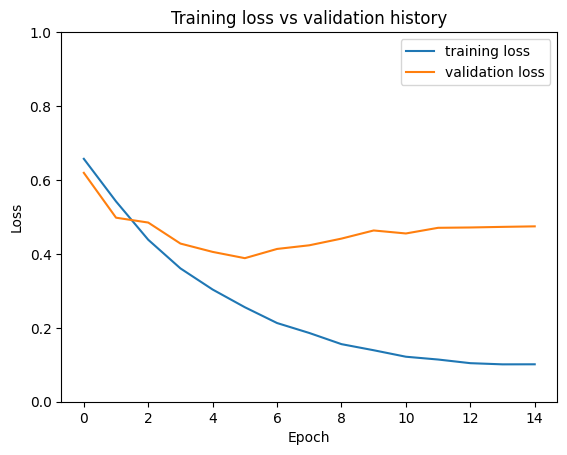

In [28]:
plt.plot(history['train_loss'], label='training loss')
plt.plot(history['val_loss'], label='validation loss')

plt.title('Training loss vs validation history')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [29]:
 model = ClassifierModel()

In [30]:
model_path = f"/kaggle/working/banglabert_cyberbullying_model_123.bin"
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [ ]:
model.to(config.DEVICE);

In [32]:
test_dataset = ClassifierDataset(df_test, tokenizer, target_list)

In [33]:
from torch.utils.data import DataLoader
test_dataloader = DataLoader(
    test_dataset, batch_size=64, collate_fn=data_collator, shuffle=False
)

In [34]:
def get_predictions(model, data_loader):
    """
    Outputs:
      predictions - 
    """
    model = model.eval()

    predictions = []
    prediction_probs = []
    target_values = []

    with torch.no_grad():
      for data in data_loader:
        input_ids = data["input_ids"].to(config.DEVICE)
        attention_mask = data["attention_mask"].to(config.DEVICE)
        targets = data["labels"].to(config.DEVICE)
        
        outputs = model(input_ids, attention_mask)
        # add sigmoid, for the training sigmoid is in BCEWithLogitsLoss
        outputs = torch.sigmoid(outputs).detach().cpu()
        # thresholding at 0.5
        preds = outputs.round()
        targets = targets.detach().cpu()
        predictions.extend(preds)
        prediction_probs.extend(outputs)
        target_values.extend(targets)
    
    predictions = torch.stack(predictions)
    prediction_probs = torch.stack(prediction_probs)
    target_values = torch.stack(target_values)
    
    return  predictions, prediction_probs, target_values


In [35]:
predictions, prediction_probs, target_values = get_predictions(model, test_dataloader)

In [36]:
predictions= predictions.numpy()
predictions

array([[1., 1., 0., 0.],
       [0., 1., 0., 1.],
       [1., 1., 0., 1.],
       ...,
       [1., 1., 1., 0.],
       [1., 1., 0., 1.],
       [0., 1., 1., 1.]], dtype=float32)

In [37]:
print(f"\npredictions:{predictions.shape} \nprediction_probs:{prediction_probs.shape} \ntarget_values:{target_values.shape}")
     


predictions:(763, 4) 
prediction_probs:torch.Size([763, 4]) 
target_values:torch.Size([763, 4])


In [38]:
from sklearn.metrics import confusion_matrix, classification_report

# Print classification report with 4 decimal digits
print(classification_report(target_values, predictions, target_names=target_list, digits=4))

                     precision    recall  f1-score   support

           Trolling     0.8467    0.7605    0.8013       334
             Insult     0.9070    0.9581    0.9319       621
        Hate Speech     0.8634    0.8534    0.8584       348
Targeted Harassment     0.8431    0.9238    0.8816       512

          micro avg     0.8700    0.8920    0.8808      1815
          macro avg     0.8650    0.8740    0.8683      1815
       weighted avg     0.8695    0.8920    0.8796      1815
        samples avg     0.8677    0.8949    0.8664      1815



In [39]:
subset_acc = (predictions == target_values).all(dim=1).float().mean().item()
print(f"Subset Accuracy: {subset_acc:.4f}")


Subset Accuracy: 0.5780


In [40]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    accuracy_score,
    precision_score,
    recall_score
)

f1 = f1_score(target_values.numpy(), predictions, average='macro')
print(f"F1 Score (macro): {f1:.4f}")
precision = precision_score(target_values, predictions, average='macro')
print(f"Precision (Macro): {precision:.4f}")

# Recall
recall = recall_score(target_values, predictions, average='macro')
print(f"Recall (Macro): {recall:.4f}")

F1 Score (macro): 0.8683
Precision (Macro): 0.8650
Recall (Macro): 0.8740


In [41]:
f1 = f1_score(target_values.numpy(), predictions, average='micro')
print(f"F1 Score (micro): {f1:.4f}")

F1 Score (micro): 0.8808


In [42]:
type(target_values)

torch.Tensor

In [43]:
df_test

,Comment,Profession,Gender,Labels,Trolling,Insult,Hate Speech,Targeted Harassment
1720,বাপ জেমন মেয়েত তেমনি হবে এটাতো তাদের রেচালা।,Actor,Female,"Insult, Hate Speech, Targeted Harassment",0,1,1,1
2702,জুতা মারি তোর চোয়ালে বেটা বেয়াদব । এজন্যই তো ত...,Singer,Female,"Insult, Targeted Harassment",0,1,0,1
4740,"সালা বেগাচেগা তুই লাইভে আসিস কি করতে, আয়নায় কো...",Social,Male,"Trolling, Insult, Targeted Harassment",1,1,0,1
4076,জুতা মার।ছাগলের বাচ্চা,Social,Male,"Insult, Targeted Harassment",0,1,0,1
2445,ওর নোংরা ছবিটা পোস্ট না করে শুধু লেখাটা রাখলেই...,Actor,Female,"Trolling, Insult",1,1,0,0
...,...,...,...,...,...,...,...,...
867,ওর মনে হয় জন্মের ঠিক নেই,Actor,Female,"Insult, Targeted Harassment",0,1,0,1
1919,নটি মাগি তোর মাইরো . আর তোরে উদুম কইরা চুদুম,Actor,Female,"Insult, Hate Speech, Targeted Harassment",0,1,1,1
2497,কিযে কষ্ট আছি বলে বোঝাতে পারবো নাহ মাননীয় স্পি...,Actor,Female,"Trolling, Insult, Hate Speech",1,1,1,0
795,তুমি ভুল শিকার করলা!বাট তুমার আচুদা ফ্যানরা এখ...,Actor,Female,"Trolling, Insult",1,1,0,0


In [44]:
df_test.columns

Index(['Comment', 'Profession', 'Gender', 'Labels', 'Trolling', 'Insult',
       'Hate Speech', 'Targeted Harassment'],
      dtype='object')

In [45]:
type(predictions)

numpy.ndarray

In [46]:
predictions = torch.tensor(predictions)

# Ensure both are float tensors
predictions = predictions.float()
target_values = target_values.float()

# Hamming Accuracy
hamming_acc = (predictions == target_values).float().mean().item()
print(f"Hamming Accuracy: {hamming_acc:.4f}")

# Hamming Loss
hamming_loss = (predictions != target_values).float().mean().item()
print(f"Hamming Loss: {hamming_loss:.4f}")


Hamming Accuracy: 0.8565
Hamming Loss: 0.1435


In [47]:
df = df_test

In [48]:
df["Pred_Trolling"] = predictions[:, 0]
df["Pred_Insult"] = predictions[:, 1]
df["Pred_Hate_Speech"] = predictions[:, 2]
df["Pred_Targeted_Harassment"] = predictions[:, 3]
cols_to_convert = [
    "Trolling", "Insult", "Hate Speech", "Targeted Harassment",
    "Pred_Trolling", "Pred_Insult", "Pred_Hate_Speech", "Pred_Targeted_Harassment"
]

df[cols_to_convert] = df[cols_to_convert].astype(int)

keep_cols = [
    "Trolling", "Insult", "Hate Speech", "Targeted Harassment",
    "Pred_Trolling", "Pred_Insult", "Pred_Hate_Speech", "Pred_Targeted_Harassment"
]

df_clean = df[keep_cols]
df_clean.to_csv("true_pred_only_seed(123).csv", index=False)

print("Saved: true_pred_only.csv")
df_clean.head()


Saved: true_pred_only.csv


,Trolling,Insult,Hate Speech,Targeted Harassment,Pred_Trolling,Pred_Insult,Pred_Hate_Speech,Pred_Targeted_Harassment
1720,0,1,1,1,1,1,0,0
2702,0,1,0,1,0,1,0,1
4740,1,1,0,1,1,1,0,1
4076,0,1,0,1,0,1,0,1
2445,1,1,0,0,1,1,0,1


In [49]:
df_clean.shape

(763, 8)